<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment_8/XAI_in_LLM_Assignment_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #08



## Akalpit Dawkhar

### **XAI in LLMs**

### Overview
This notebook demonstrates various dimensionality reduction techniques to visualize the embeddings of text data using Word2Vec. We use PCA, t-SNE, and UMAP to explore the high-dimensional embeddings, and provide visual interpretations of the document clusters across different classes.

In [50]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques/Assignment_8" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
# !pip install -q -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "/content/Explainable-techniques/Assignment_8"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'Explainable-techniques'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 263 (delta 31), reused 24 (delta 9), pack-reused 199 (from 1)
Receiving objects: 100% (263/263), 8.64 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/Explainable-techniques/Assignment_8
Explainable-techniques/  requirements.txt  XAI_in_LLM_Assignment_08.ipynb


# 1. Importing Neccessary libraries and data & preprocessing the data

The dataset used in this notebook is the 20 Newsgroups dataset, which contains documents categorized into 20 different classes, covering topics ranging from religion to sports and technology.

After loading the dataset, we preprocess the text by removing non-alphabetic characters, converting to lowercase, tokenizing, and removing stopwords and punctuation. This helps in reducing noise and ensuring that only meaningful words are used for further analysis.

In [51]:
# Install necessary libraries
!pip install -q sentence-transformers umap-learn gensim

# Restart the runtime after installation if necessary

In [52]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from gensim.models import KeyedVectors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.datasets import fetch_20newsgroups
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# Load the pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

Word2Vec is a popular pre-trained word embedding model that provides 300-dimensional vector representations of words based on their context in a large corpus. These embeddings capture semantic relationships between words, making them useful for downstream tasks.

In this notebook, we load the pre-trained Word2Vec model using Gensim's API. To represent entire documents, we compute an average of the embeddings of all words present in each document. This averaging provides a fixed-length vector representation for each document, which can be further analyzed and visualized.

In [54]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('english'))
punctuation = set(punctuation)

def preprocess(text):
    """
    Preprocesses the input text by performing the following steps:
    - Converts text to lowercase
    - Removes non-alphabetic characters
    - Tokenizes the text into words
    - Removes stopwords and punctuation

    Parameters:
    text (str): The input text to preprocess.

    Returns:
    list: A list of processed tokens.
    """
    """
    Preprocess the input text by converting to lowercase, removing non-alphabetic characters, tokenizing, and removing stopwords and punctuation.

    Parameters:
    text (str): The input text to preprocess.

    Returns:
    list: A list of processed tokens.
    """
    # Lowercase the text
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens

# Preprocess the sampled texts
num_samples = 2000  # Adjust as needed
texts_sampled = texts[:num_samples]
labels_sampled = labels[:num_samples]
category_names = fetch_20newsgroups().target_names
label_names = pd.Series([category_names[label] for label in labels_sampled])

processed_texts = [preprocess(text) for text in texts_sampled]


# 2. Embeddings Using Word2Vec

In [55]:
def get_document_embedding(tokens, model):
    """
    Computes the document embedding by averaging the embeddings of the tokens present in the Word2Vec model.
    If no valid embeddings are found for any tokens, returns a zero vector.

    Parameters:
    tokens (list): List of tokens from the document.
    model (gensim.models.KeyedVectors): Pre-trained Word2Vec model.

    Returns:
    numpy.ndarray: The averaged embedding of the document.
    """
    """
    Compute the document embedding by averaging the embeddings of the tokens present in the Word2Vec model.

    Parameters:
    tokens (list): List of tokens from the document.
    model (gensim.models.KeyedVectors): Pre-trained Word2Vec model.

    Returns:
    numpy.ndarray: The averaged embedding of the document.
    """
    valid_embeddings = []
    for token in tokens:
        if token in model:
            valid_embeddings.append(model[token])
    if valid_embeddings:
        # Average the embeddings
        document_embedding = np.mean(valid_embeddings, axis=0)
    else:
        # If no valid embeddings, return a zero vector
        document_embedding = np.zeros(model.vector_size)
    return document_embedding

# Compute embeddings for all documents
embeddings = np.array([get_document_embedding(tokens, word2vec_model) for tokens in processed_texts])
print(f"Embedding shape: {embeddings.shape}")


Embedding shape: (2000, 300)


In [56]:
def plot_embeddings(embeddings, labels, title):
    """
    Plots the reduced embeddings using a scatter plot with class labels.

    Parameters:
    embeddings (numpy.ndarray): The 2D reduced embeddings to plot.
    labels (list): List of labels for each point in the embeddings.
    title (str): The title of the plot.

    Returns:
    None
    """
    """
    Plot the reduced embeddings using a scatter plot with class labels.

    Parameters:
    embeddings (numpy.ndarray): The 2D reduced embeddings to plot.
    labels (list): List of labels for each point in the embeddings.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 8))
    num_classes = len(set(labels))
    palette = sns.color_palette("hls", num_classes)
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=label_names, legend='full', palette=palette, s=30)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


# 3. Visulaisation of embeddings


To visualize the high-dimensional document embeddings, we employ three popular dimensionality reduction techniques:

1. **PCA (Principal Component Analysis)**: A linear dimensionality reduction method that projects the data onto the directions of maximum variance. It helps in visualizing the overall structure of the embeddings in two dimensions.

2. **t-SNE (t-distributed Stochastic Neighbor Embedding)**: A nonlinear technique that focuses on preserving local distances and forming clusters of similar data points. It is particularly useful for discovering subgroups in the data.

3. **UMAP (Uniform Manifold Approximation and Projection)**: A nonlinear method similar to t-SNE but designed to preserve both local and global structure. It aims to strike a balance between capturing small clusters and overall relationships.

We define a function to plot the reduced embeddings, where each document is represented as a point in a 2D plane, and different colors represent different classes.

### Applying PCA for Dimensionality Reduction
Principal Component Analysis (PCA) is used to reduce the dimensionality of the document embeddings to 2 dimensions for visualization purposes.

PCA reduced shape: (2000, 2)


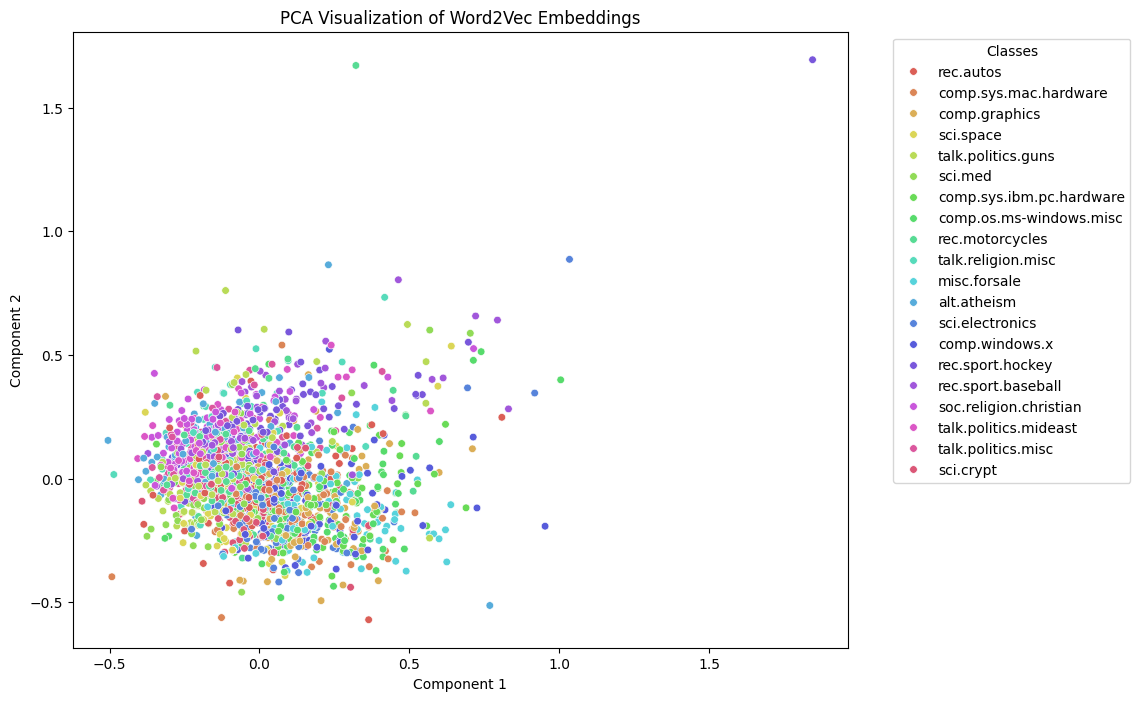

In [57]:
# Apply PCA

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA reduced shape: {embeddings_pca.shape}")

plot_embeddings(embeddings_pca, labels_sampled, 'PCA Visualization of Word2Vec Embeddings')

### Interpretation of PCA Plot
The PCA plot shows how the embeddings are spread out across two principal components. While some clusters are visible, the overlap suggests that PCA may not be sufficient for clearly distinguishing all classes in the dataset.

### Applying t-SNE for Dimensionality Reduction
t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique used to visualize high-dimensional data in a lower-dimensional space. Unlike PCA, which is a linear technique, t-SNE focuses on preserving the local structure of the data, making it particularly effective for clustering and revealing complex relationships within the data.

The key features of t-SNE include:
- **Preservation of Local Structure**: t-SNE aims to place similar data points closer together in the reduced space, thereby capturing local similarities well.
- **Nonlinear Mapping**: It can handle complex, non-linear relationships that are not easily captured by linear techniques like PCA.

In this notebook, we use t-SNE to visualize the Word2Vec embeddings in two dimensions. The technique is especially useful for observing clusters that are not evident with linear techniques, providing an intuitive view of how well the Word2Vec model captures document similarities.

t-SNE reduced shape: (2000, 2)


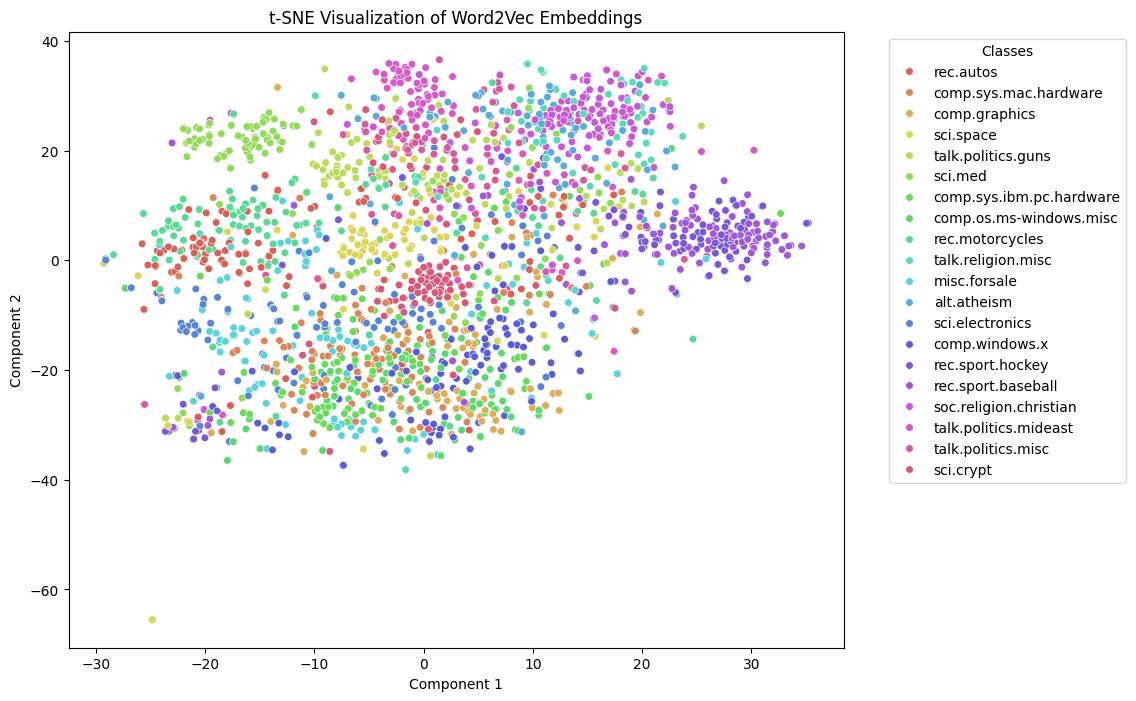

In [58]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
print(f"t-SNE reduced shape: {embeddings_tsne.shape}")

plot_embeddings(embeddings_tsne, labels_sampled, 't-SNE Visualization of Word2Vec Embeddings')

### Interpretation of t-SNE Plot
t-SNE captures more local structure, which helps in visualizing smaller clusters of similar documents. Compared to PCA, we see a clearer separation of some of the classes, but there is still some overlap.

### Applying UMAP for Dimensionality Reduction
UMAP (Uniform Manifold Approximation and Projection) is another nonlinear dimensionality reduction technique that aims to preserve the global structure of data.

In [59]:
def plot_embeddings_umap(embeddings, labels, title):
    """
   Similar to plot_embeddings, but is optimized for UMAP to zoom in on the results of UMAP.

    Parameters:
    embeddings (numpy.ndarray): The 2D reduced embeddings to plot.
    labels (list): List of labels for each point in the embeddings.
    title (str): The title of the plot.

    Returns:
    None
    """
    plt.figure(figsize=(20, 15))
    num_classes = len(set(labels))
    palette = sns.color_palette("hls", num_classes)
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=label_names, legend='full', palette=palette, s=30)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

UMAP reduced shape: (2000, 2)


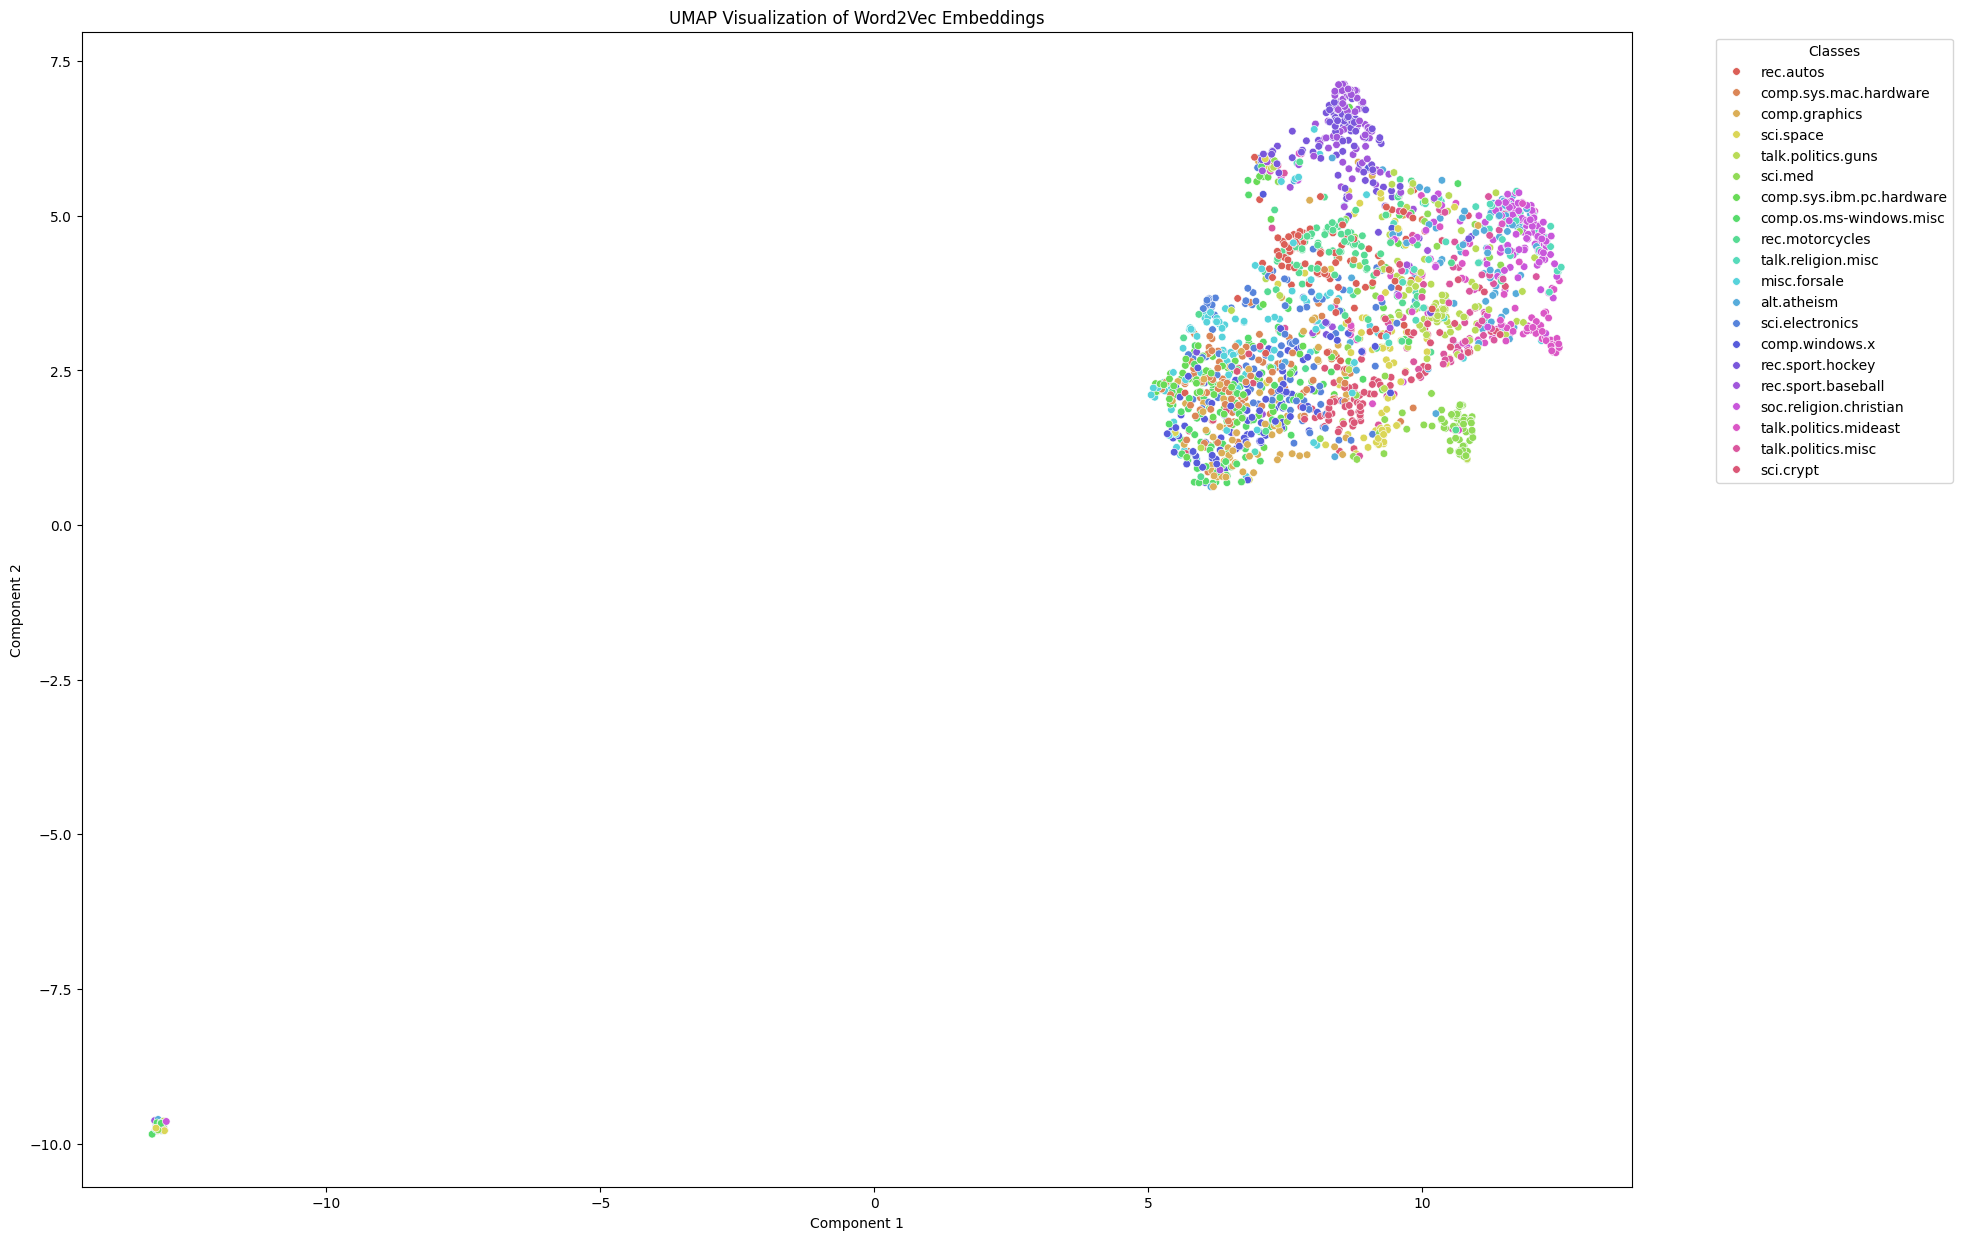

In [60]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)
print(f"UMAP reduced shape: {embeddings_umap.shape}")

plot_embeddings_umap(embeddings_umap, labels_sampled, 'UMAP Visualization of Word2Vec Embeddings')


### Interpretation of UMAP Plot
UMAP maintains both local and global relationships better, revealing more distinct clusters of documents. The UMAP plot demonstrates the structure of the dataset in an intuitive manner, showing both tight clustering and some degree of class separation.


# 3. Summary

### Summary of Results
In this notebook, we visualized document embeddings generated from a pre-trained Word2Vec model using three different dimensionality reduction techniques: PCA, t-SNE, and UMAP. Each technique provided a unique view of the data structure:

- **PCA** gave a general overview of the variance in the dataset, showing some separability between classes but also significant overlap. This suggests that while the embeddings capture some distinctions, PCA might not capture complex nonlinear relationships.

- **t-SNE** focused on preserving local neighborhoods, resulting in clearer clusters for some document classes. It is effective for visualizing smaller groups of similar data points, but the plot may vary significantly with different hyperparameters.

- **UMAP** provided the clearest representation of both local and global relationships, resulting in distinct and interpretable clusters for many of the classes. It strikes a good balance between maintaining the local structure of the data and showing the overall distribution.

### Comparison of PCA, t-SNE, and UMAP Plots
- **PCA vs. t-SNE**: PCA provides a linear reduction and highlights the variance in the dataset but often lacks the ability to separate complex clusters. t-SNE, on the other hand, effectively separates smaller clusters and provides a more detailed view of local neighborhoods, although it may not capture the global structure well.

- **PCA vs. UMAP**: While PCA provides an overview of data variance, UMAP better preserves both local and global structures, allowing for clearer class separation. UMAP often provides a more interpretable plot compared to PCA, especially for high-dimensional and complex data.

- **t-SNE vs. UMAP**: t-SNE focuses primarily on local structure, which can lead to inconsistencies in visualizing the broader relationships within the data. UMAP preserves both local and global structures, offering a more balanced and consistent representation. UMAP also tends to produce more reproducible results compared to t-SNE.

Overall, **UMAP** stands out as the best method for this dataset, as it balances both local and global data structures, providing a clear and interpretable visualization. These visualizations help us understand how well the Word2Vec embeddings capture the relationships between different documents, which is essential for downstream tasks like classification or clustering.

# 4. Reference



1.   ChatGPT (For documentation)
2.   https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/embedding-visualization.ipynb#scrollTo=sdgLJfLHW9--

